In [31]:
import json
import warnings
from collections import namedtuple

import joblib
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, fbeta_score, roc_auc_score, accuracy_score, ConfusionMatrixDisplay
from sklearn.preprocessing import OneHotEncoder
from sklearn.tree import DecisionTreeClassifier, plot_tree

sns.set()
warnings.filterwarnings("ignore")

In [32]:
data = pd.read_csv("data/train_data.csv")

In [33]:
data.head()

,Customer Id,YearOfObservation,Insured_Period,Residential,Building_Painted,Building_Fenced,Garden,Settlement,Building Dimension,Building_Type,Date_of_Occupancy,NumberOfWindows,Geo_Code,Claim
0,H14663,2013,1.0,0,N,V,V,U,290.0,1,1960.0,.,1053,0
1,H2037,2015,1.0,0,V,N,O,R,490.0,1,1850.0,4,1053,0
2,H3802,2014,1.0,0,N,V,V,U,595.0,1,1960.0,.,1053,0
3,H3834,2013,1.0,0,V,V,V,U,2840.0,1,1960.0,.,1053,0
4,H5053,2014,1.0,0,V,N,O,R,680.0,1,1800.0,3,1053,0


## Understanding & Preparing your Data

In [34]:
data.shape

(7160, 14)

In [35]:
data["Claim"].value_counts()

0    5526
1    1634
Name: Claim, dtype: int64

### Transforming Existing Features

In [36]:
data.describe()

,YearOfObservation,Insured_Period,Residential,Building Dimension,Building_Type,Date_of_Occupancy,Claim
count,7160.000000,7160.000000,7160.000000,7054.000000,7160.000000,6652.000000,7160.000000
mean,2013.669553,0.909758,0.305447,1883.727530,2.186034,1964.456404,0.228212
std,1.383769,0.239756,0.460629,2278.157745,0.940632,36.002014,0.419709
min,2012.000000,0.000000,0.000000,1.000000,1.000000,1545.000000,0.000000
25%,2012.000000,0.997268,0.000000,528.000000,2.000000,1960.000000,0.000000
50%,2013.000000,1.000000,0.000000,1083.000000,2.000000,1970.000000,0.000000
75%,2015.000000,1.000000,1.000000,2289.750000,3.000000,1980.000000,0.000000
max,2016.000000,1.000000,1.000000,20940.000000,4.000000,2016.000000,1.000000


In [37]:
data.describe(include='O')

,Customer Id,Building_Painted,Building_Fenced,Garden,Settlement,NumberOfWindows,Geo_Code
count,7160,7160,7160,7153,7160,7160,7058
unique,7160,2,2,2,2,11,1307
top,H14663,V,N,O,R,.,6088
freq,1,5382,3608,3602,3610,3551,143


In [38]:
data["NumberOfWindows"].value_counts()

   .    3551
4        939
3        844
5        639
2        363
6        306
7        211
8        116
1         75
>=10      67
9         49
Name: NumberOfWindows, dtype: int64

In [39]:
data["NumberOfWindows"] = data["NumberOfWindows"].replace({"   .": "0", ">=10": "10"}).astype(int)

### Handling Missing Values

In [40]:
# How many rows contain a missing value?
data.isnull().any(axis=1).sum()

617

In [41]:
# How many missing values are in each column?
data.isnull().sum()

Customer Id             0
YearOfObservation       0
Insured_Period          0
Residential             0
Building_Painted        0
Building_Fenced         0
Garden                  7
Settlement              0
Building Dimension    106
Building_Type           0
Date_of_Occupancy     508
NumberOfWindows         0
Geo_Code              102
Claim                   0
dtype: int64

In [42]:
data.dropna(how="any", inplace=True)

In [43]:
data.shape

(6543, 14)

### Encoding Features

In [44]:
categorical_columns = ["Building_Painted", "Building_Fenced", "Garden", "Settlement"]

In [45]:
data[categorical_columns].head()

,Building_Painted,Building_Fenced,Garden,Settlement
0,N,V,V,U
1,V,N,O,R
2,N,V,V,U
3,V,V,V,U
4,V,N,O,R


In [46]:
encoder = OneHotEncoder(handle_unknown="ignore", drop="first", sparse=False)
encoder.fit(data[categorical_columns])

OneHotEncoder(drop='first', handle_unknown='ignore', sparse=False)

In [47]:
data[categorical_columns] = encoder.transform(data[categorical_columns])

In [48]:
data[categorical_columns].head()

,Building_Painted,Building_Fenced,Garden,Settlement
0,0.0,1.0,1.0,1.0
1,1.0,0.0,0.0,0.0
2,0.0,1.0,1.0,1.0
3,1.0,1.0,1.0,1.0
4,1.0,0.0,0.0,0.0


### Creating New Features

In [49]:
data["age_of_building"] = data["YearOfObservation"] - data["Date_of_Occupancy"]

In [50]:
data['age_of_building'].describe()

count    6543.000000
mean       49.240715
std        35.787297
min         0.000000
25%        32.000000
50%        46.000000
75%        55.000000
max       469.000000
Name: age_of_building, dtype: float64

<AxesSubplot:xlabel='age_of_building', ylabel='Density'>

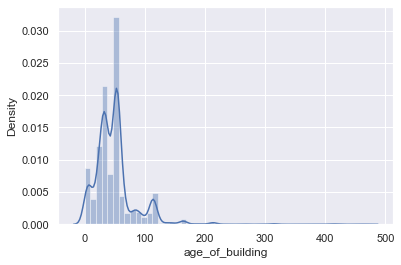

In [51]:
sns.distplot(data["age_of_building"])

### Checking Correlation Between Features

In [52]:
corr_df = data[categorical_columns].corr()

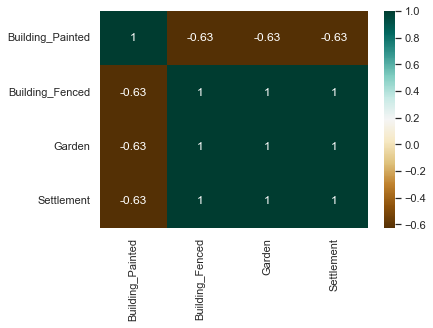

In [54]:
sns.heatmap(corr_df, annot=True, cmap="BrBG")
plt.show()

### Dropping Features

In [55]:
dropped_columns = ["Geo_Code", "Customer Id", "YearOfObservation", "Date_of_Occupancy", "Garden", "Settlement"]

In [56]:
data.drop(dropped_columns, axis=1, inplace=True)

In [57]:
data.shape

(6543, 9)

### Splitting Dataset for Modelling

In [58]:
target = data.pop("Claim")

In [59]:
X_train, X_test, y_train, y_test = train_test_split(
    data, target, test_size=0.3, stratify=target, random_state=42)

In [60]:
print(X_train.shape)

(4580, 8)


In [61]:
print(X_test.shape)

(1963, 8)


## Modelling

In [62]:
def train_and_evaluate_model(model, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    print("Classification Report: Train set\n")
    print(classification_report(y_train, y_train_pred))

    print("Classification Report: Test set\n")
    print(classification_report(y_test, y_test_pred))

    print("Confusion Matrix: Train set\n")
    ConfusionMatrixDisplay.from_predictions(y_train, y_train_pred, labels=[0, 1])
    plt.grid(False)
    plt.show()

    print("Confusion Matrix: Test set\n")
    ConfusionMatrixDisplay.from_predictions(y_test, y_test_pred, labels=[0, 1])
    plt.grid(False)
    plt.show()

    return model

### Decision Tree

In [63]:
model_dt = DecisionTreeClassifier(class_weight="balanced", splitter="random", random_state=42)

Classification Report: Train set

              precision    recall  f1-score   support

           0       1.00      0.99      1.00      3522
           1       0.98      1.00      0.99      1058

    accuracy                           0.99      4580
   macro avg       0.99      1.00      0.99      4580
weighted avg       0.99      0.99      0.99      4580

Classification Report: Test set

              precision    recall  f1-score   support

           0       0.81      0.79      0.80      1510
           1       0.35      0.38      0.37       453

    accuracy                           0.69      1963
   macro avg       0.58      0.59      0.58      1963
weighted avg       0.70      0.69      0.70      1963

Confusion Matrix: Train set



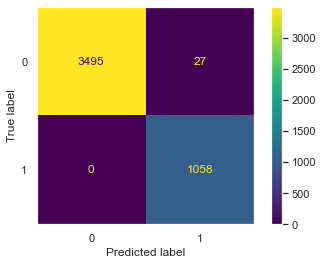

Confusion Matrix: Test set



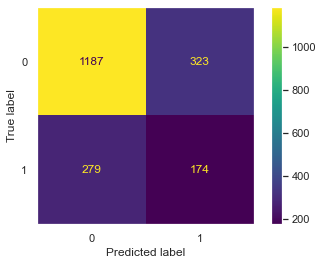

DecisionTreeClassifier(class_weight='balanced', random_state=42,
                       splitter='random')

In [64]:
train_and_evaluate_model(model_dt, X_train, X_test, y_train, y_test)

## Hyperparameter Tuning

### Tuning Max Depth

In [67]:
results = {}

In [68]:
for depth in range(3, 51):
    model = DecisionTreeClassifier(
        class_weight="balanced", splitter="random", max_depth=depth, random_state=42)
    model.fit(X_train, y_train)
    ypred = model.predict(X_test)
    
    f2score = fbeta_score(y_test, ypred, beta=2.0)

    print(f"Max Depth: {depth}")
    print(f"F Score: {f2score}")

    results[depth] = f2score

Max Depth: 3
F Score: 0.4145555043758637
Max Depth: 4
F Score: 0.5324074074074076
Max Depth: 5
F Score: 0.25276841598459315
Max Depth: 6
F Score: 0.5130228887134965
Max Depth: 7
F Score: 0.5655430711610486
Max Depth: 8
F Score: 0.5090180360721442
Max Depth: 9
F Score: 0.49760191846522783
Max Depth: 10
F Score: 0.46919624643002855
Max Depth: 11
F Score: 0.4750499001996008
Max Depth: 12
F Score: 0.4411764705882353
Max Depth: 13
F Score: 0.459480418766964
Max Depth: 14
F Score: 0.4399837793998378
Max Depth: 15
F Score: 0.43794105437941055
Max Depth: 16
F Score: 0.4180395387149918
Max Depth: 17
F Score: 0.37875668999588313
Max Depth: 18
F Score: 0.4285134037367993
Max Depth: 19
F Score: 0.3800170794192997
Max Depth: 20
F Score: 0.3945111492281304
Max Depth: 21
F Score: 0.37627551020408156
Max Depth: 22
F Score: 0.39249146757679176
Max Depth: 23
F Score: 0.3566796368352788
Max Depth: 24
F Score: 0.3680585449849333
Max Depth: 25
F Score: 0.36363636363636365
Max Depth: 26
F Score: 0.376297577

In [69]:
best_depth = sorted(results, key=lambda x: results[x], reverse=True)[0]
print(f"Best Depth: {best_depth}")

Best Depth: 7


In [70]:
tuned_model = DecisionTreeClassifier(class_weight="balanced", splitter="random", max_depth=best_depth, random_state=42)

Classification Report: Train set

              precision    recall  f1-score   support

           0       0.88      0.64      0.74      3522
           1       0.37      0.71      0.49      1058

    accuracy                           0.66      4580
   macro avg       0.63      0.68      0.62      4580
weighted avg       0.76      0.66      0.68      4580

Classification Report: Test set

              precision    recall  f1-score   support

           0       0.86      0.63      0.73      1510
           1       0.35      0.67      0.46       453

    accuracy                           0.64      1963
   macro avg       0.61      0.65      0.60      1963
weighted avg       0.75      0.64      0.67      1963

Confusion Matrix: Train set



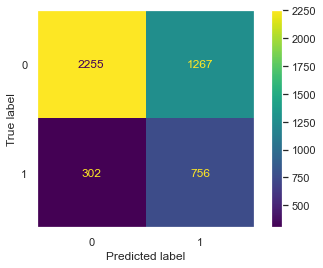

Confusion Matrix: Test set



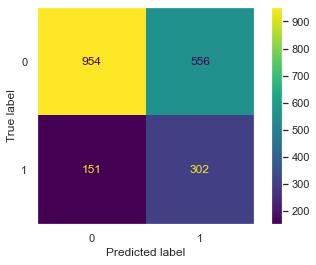

DecisionTreeClassifier(class_weight='balanced', max_depth=7, random_state=42,
                       splitter='random')

In [71]:
train_and_evaluate_model(tuned_model, X_train, X_test, y_train, y_test)